In [ ]:
from databaseCommunication import getNCount
from dataframeFormating import fitRun_3b_linear, N_linear, createLabeledDataFrame, createLabeledDataFrame_2, fitRun_1and3b, fitRun_1and3b_2, fitRun_3b, fitRun_3b_2, getReducedDataframe, getReducedResults, deltaTime, N_polarized, N_polarized_pure3b
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

#getNCount(117000)

In [ ]:
from databaseCommunication import executeGetQuery

def getImage(imageID):
    sql_query = """SELECT runID FROM ciceroOut ORDER BY runID DESC LIMIT 1;"""
    image = executeGetQuery(sql_query)[0][0]
    return image

sql_query = """SELECT atoms, noAtoms, dark FROM images WHERE imageID = 121963;"""
image = executeGetQuery(sql_query)[0]

In [18]:
atoms = np.frombuffer(image[0], dtype = np.int)
noAtoms = np.frombuffer(image[1], dtype = np.int)
dark = np.frombuffer(image[2], dtype = np.int)

TypeError: Invalid shape (786432,) for image data

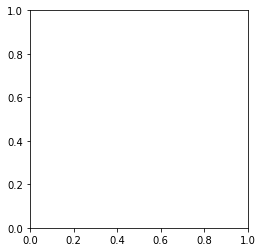

In [19]:
plt.figure()
plt.imshow(atoms)
plt.show()

In [93]:
def getCameraDimensions(imageID):
    sql_query = "SELECT cameraID_fk FROM images WHERE imageID = " + str(imageID) + ";"
    cameraID = executeGetQuery(sql_query)[0][0]
    sql_query = "SELECT cameraHeight, cameraWidth FROM cameras WHERE cameraID = " + str(cameraID) + ";"
    height, width = executeGetQuery(sql_query)[0]
    return height, width

def getImageDatabase(imageID):
    sql_query = """SELECT atoms, noAtoms, dark FROM images WHERE imageID = """ + str(imageID) + """;"""
    byteArrayList = list(executeGetQuery(sql_query)[0])
    i = 0
    for i in range(len(byteArrayList)):
        if type(byteArrayList[i]) == str:
            byteArrayList[i] = bytearray(byteArrayList[i], 'utf-8')
    return byteArrayList  # returns a list of 3 bytearrays


def readDatabaseFile(imageID): # path is the imageID in the db, not the filepath
    cameraHeight, cameraWidth = getCameraDimensions(imageID) # look at the config file to make sure there is no conflict zith height and width
    if (cameraHeight == 1 and cameraWidth == 1):
        imageData = [np.zeros(1, dtype = np.uint16).reshape(1,1)]*3
    try:
        byteArrayList = getImageDatabase(imageID)
        # imageData = [np.frombuffer(byteArrayList[0], dtype=np.uint16).reshape(cameraHeight, cameraWidth),
        #              np.frombuffer(byteArrayList[1], dtype=np.uint16).reshape(cameraHeight, cameraWidth),
        #              np.frombuffer(byteArrayList[2], dtype=np.uint16).reshape(cameraHeight, cameraWidth)]
        imageData = [np.frombuffer(byteArrayList[0], dtype=np.uint16).reshape(cameraHeight, cameraWidth),
                     np.frombuffer(byteArrayList[1], dtype=np.uint16).reshape(cameraHeight, cameraWidth),
                     np.frombuffer(byteArrayList[2], dtype=np.uint16).reshape(cameraHeight, cameraWidth)]
    except Exception as e:
        print(str(e))
    return imageData

In [180]:
from databaseCommunication import *
from dataframeFormating import *

def createDataFrame(imageIDList):
    df_size = len(imageIDList)
    dictionnary = {'imageID' : [], 'BECHoldTime' : [], 'ODT3_Comp' : [], 'nCount' : [], 'xWidth' : [], 'yWidth' : []}
    df = pd.DataFrame(dictionnary)
    for imageID in imageIDList:
        runID = getRunIDFromImageID(imageID)
        sql_query = "SELECT BECHoldTime, ODT3_Comp FROM ciceroOut WHERE runID = {} ;".format(runID)
        BECHoldTime, ODT3_Comp = executeGetQuery(sql_query)[0][:]
        sql_query = "SELECT nCount, xWidth, yWidth FROM nCounts WHERE runID_fk = {} ;".format(runID)
        nCount, xWidth, yWidth = executeGetQuery(sql_query)[0][:]
        df = df.append({'imageID' : int(round(imageID)), 'BECHoldTime' : BECHoldTime, 'ODT3_Comp' : ODT3_Comp, 'nCount' : nCount, 'xWidth' : xWidth, 'yWidth' : yWidth, 'imageData' : readDatabaseFile(imageID)}, ignore_index = True)
    return df

def createLabeledDataFrame_2(labels):
    imageIDList = []
    for label in labels:
        imageIDList += list(range(label[1][0], label[1][1]+1))
    field_direction = []
    TOF_in_situ = []
    for imageID in imageIDList:
        for label in labels:
            if imageID in range(label[1][0], label[1][1]+1):
                field_direction += [label[0][0]]
                TOF_in_situ += [label[0][1]]
    df = createDataFrame(imageIDList)
    df['field_direction'] = field_direction
    df['TOF_in_situ'] = TOF_in_situ
    return df

def createAbsorbImg(imageData):
    correctedNoAtom = imageData[1] - imageData[2]
    absorbImg = np.maximum(imageData[0]-imageData[2], .1)/(np.maximum(correctedNoAtom, .1))  
    minT = np.exp(-5)
    temp = np.empty(imageData[0].shape)
    temp.fill(minT)
    absorbImg = np.maximum(absorbImg, temp)
    return -np.log(absorbImg)

In [181]:
# [ODT3_PD], [imageID_start, imageID_end]
labels = [[['Bz', 'in_situ'], [121968, 122042]],
          [['By', 'in_situ'], [122043, 122117]],
          [['Bz', 'TOF_bandmap'], [122164, 122237]],
          [['By', 'TOF_bandmap'], [122239, 122312]]
         ]
excluded = []

x1, x2 = 1100, 1250
y1, y2 = 825, 975
#df = createLabeledDataFrame_2(labels)
#df['BECHoldTime'] = df['BECHoldTime'].astype(float)
#for index, row in df.iterrows():
#    df.at[index, 'imageData'] = createAbsorbImg(row['imageData'])[y1:y2, x1:x2]
df1 = df.copy()
for index, row in df.iterrows():
    df.at[index, 'imageData'] = -np.log(df['imageData'][index])
#df.to_pickle('data_save_210408.pickle')

In [206]:
df1 = df.copy()
df1 = df1.sort_values(by = ["ODT3_Comp"])

In [207]:
df_situ = df[df['TOF_in_situ'] == 'in_situ']
df_TOF = df[df['TOF_in_situ'] == 'TOF_bandmap']
df_z_situ = df_situ[df_situ['field_direction'] == 'Bz']
df_y_situ = df_situ[df_situ['field_direction'] == 'By']
df_z_TOF = df_TOF[df_TOF['field_direction'] == 'Bz']
df_y_TOF = df_TOF[df_TOF['field_direction'] == 'By']

df1_situ = df1[df1['TOF_in_situ'] == 'in_situ']
df1_TOF = df1[df1['TOF_in_situ'] == 'TOF_bandmap']
df1_z_situ = df1_situ[df1_situ['field_direction'] == 'Bz']
df1_y_situ = df1_situ[df1_situ['field_direction'] == 'By']
df1_z_TOF = df1_TOF[df1_TOF['field_direction'] == 'Bz']
df1_y_TOF = df1_TOF[df1_TOF['field_direction'] == 'By']

In [208]:
df1

imageID  BECHoldTime ODT3_Comp    nCount     xWidth    yWidth  \
274  122289.0         10.0       1.2   52858.0   43.99680  28.24800   
246  122261.0         10.0       1.2   22845.0   54.62240   4.13486   
90   122058.0         20.0       1.2    -880.0    7.61912   5.58437   
101  122069.0         20.0       1.2    -191.0    9.48596  19.90230   
275  122290.0         10.0       1.2   13293.0  211.04400  24.07110   
..        ...          ...       ...       ...        ...       ...   
99   122067.0         20.0       6.0  105942.0    9.50871   5.13501   
218  122232.0         10.0       6.0  104755.0   28.57670  31.49530   
210  122224.0         10.0       6.0  104734.0   20.74210  35.38190   
122  122090.0         20.0       6.0   65609.0    9.02325  13.89670   
0    121968.0         20.0       6.0   14873.0    9.26709  14.62180   

                                             imageData field_direction  \
274                                                 []              By   
246                                                 []              By   
90   [[-0.07847161544149531, -0.03670136685042796, ...              By   
101  [[-0.20763936477824455, 0.15415067982725836, -...              By   
275                                                 []              By   
..                                                 ...             ...   
99   [[0.031010236742560322, 0.02715098906595086, -...              By   
218                                                 []              Bz   
210                                                 []              Bz   
122  [[-0.021819047394639673, 0.04652001563489282, ...              By   
0    [[0.12361395596717664, 0.08961215868968717, 0....              Bz   

     TOF_in_situ  
274  TOF_bandmap  
246  TOF_bandmap  
90       in_situ  
101      in_situ  
275  TOF_bandmap  
..           ...  
99       in_situ  
218  TOF_bandmap  
210  TOF_bandmap  
122      in_situ  
0        in_situ  

[298 rows x 9 columns]

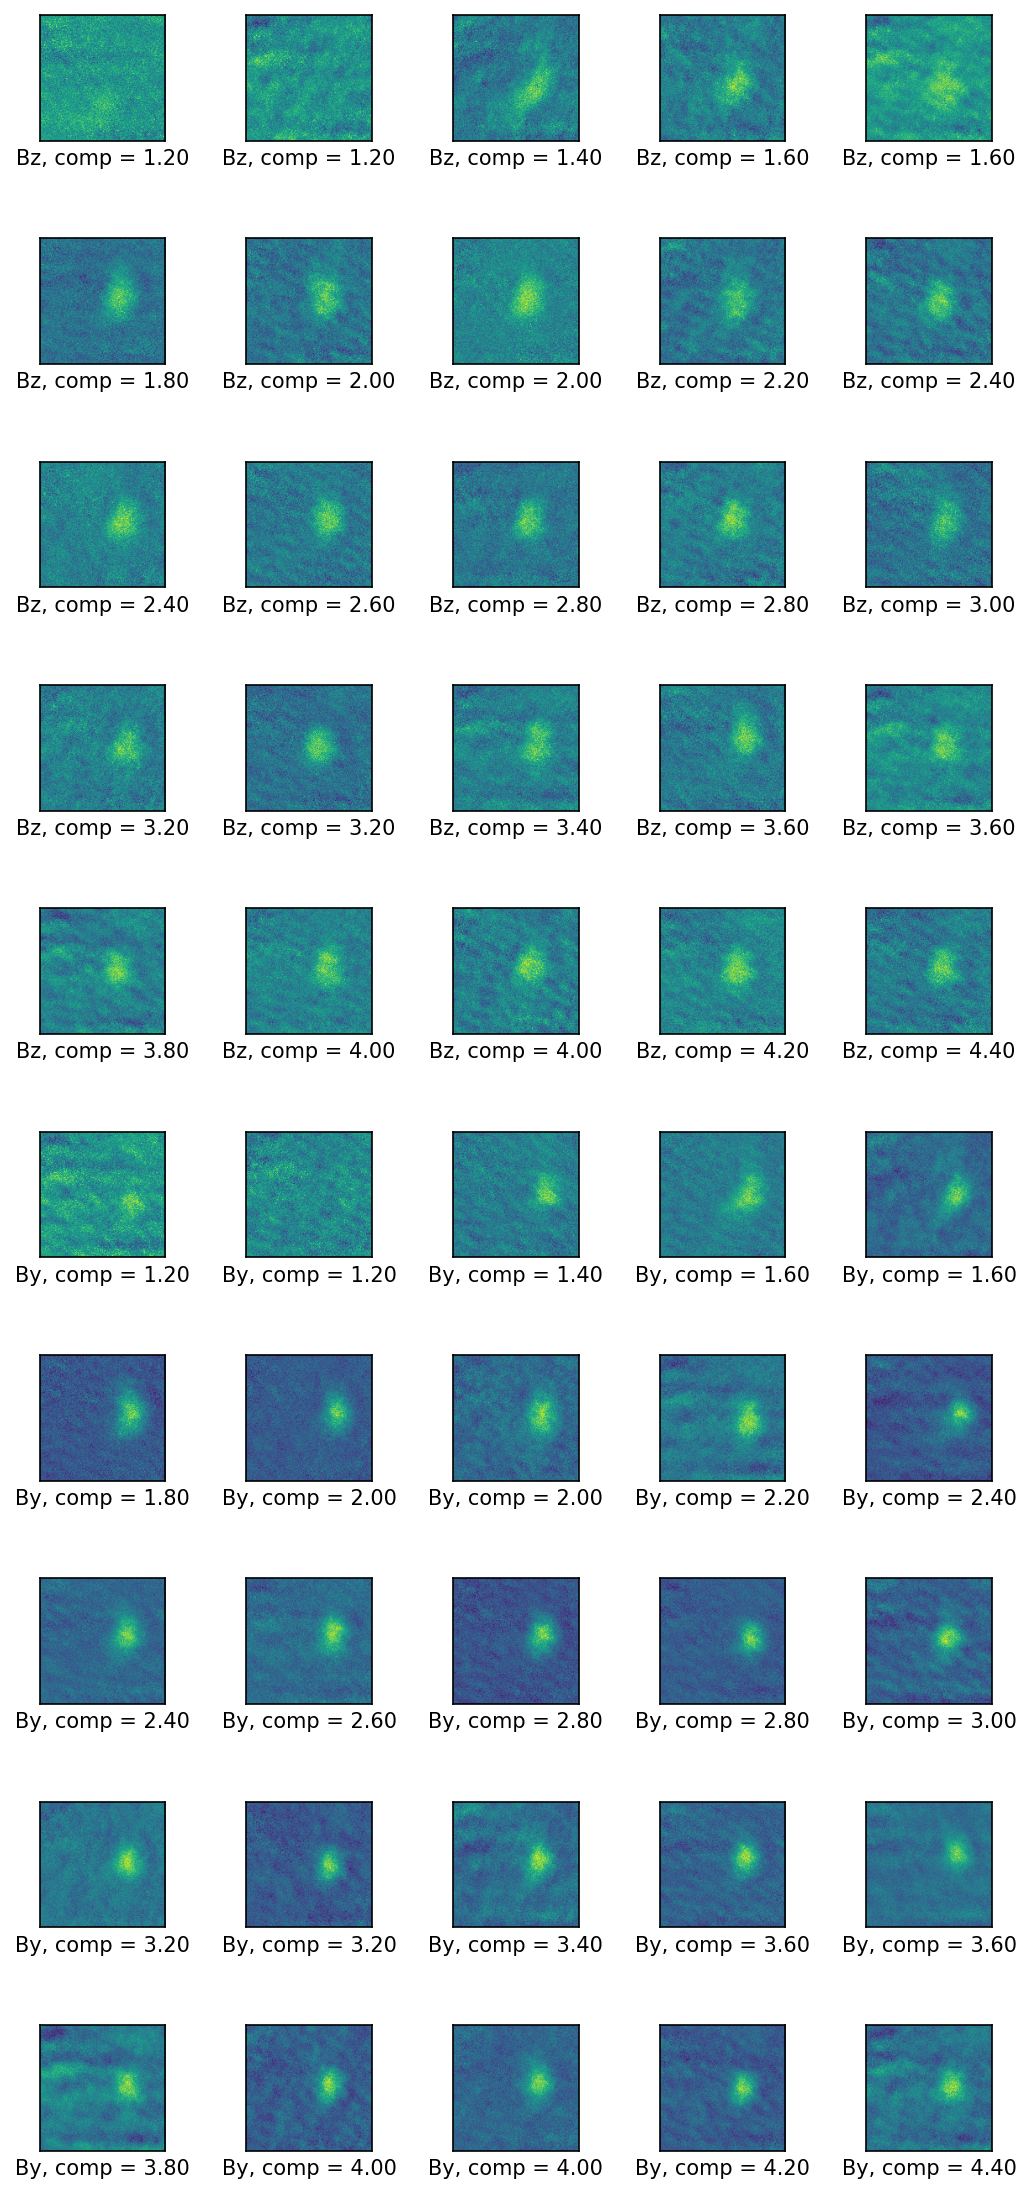

In [234]:
nrow = 10
ncol = 5
fig, ax = plt.subplots(figsize = (7,15), nrows=nrow, ncols=ncol, dpi = 150)
fig.tight_layout(pad=0.8)
i = 0
time = np.linspace(0, 200, 1000)

for row in ax:
    for col in row:
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        if i <= round(nrow*ncol/2)-1:
            label = "Bz, comp = " + str(round(df1_z_situ.iloc[i*2]['ODT3_Comp'],2))
            col.imshow(df1_z_situ.iloc[i*2]['imageData'])
        else:
            j = i - round(nrow*ncol/2)
            label = "By, comp = " + str(round(df1_y_situ.iloc[j*2]['ODT3_Comp'],2))
            col.imshow(df1_y_situ.iloc[j*2]['imageData'])
        col.set_xlabel(label)
        #print(i, label)
        i += 1

#plt.figure()
#plt.imshow(df.iloc[2]['imageData'])
fig.patch.set_facecolor('white')
plt.savefig('fig1.png', transparent=False)
plt.show()

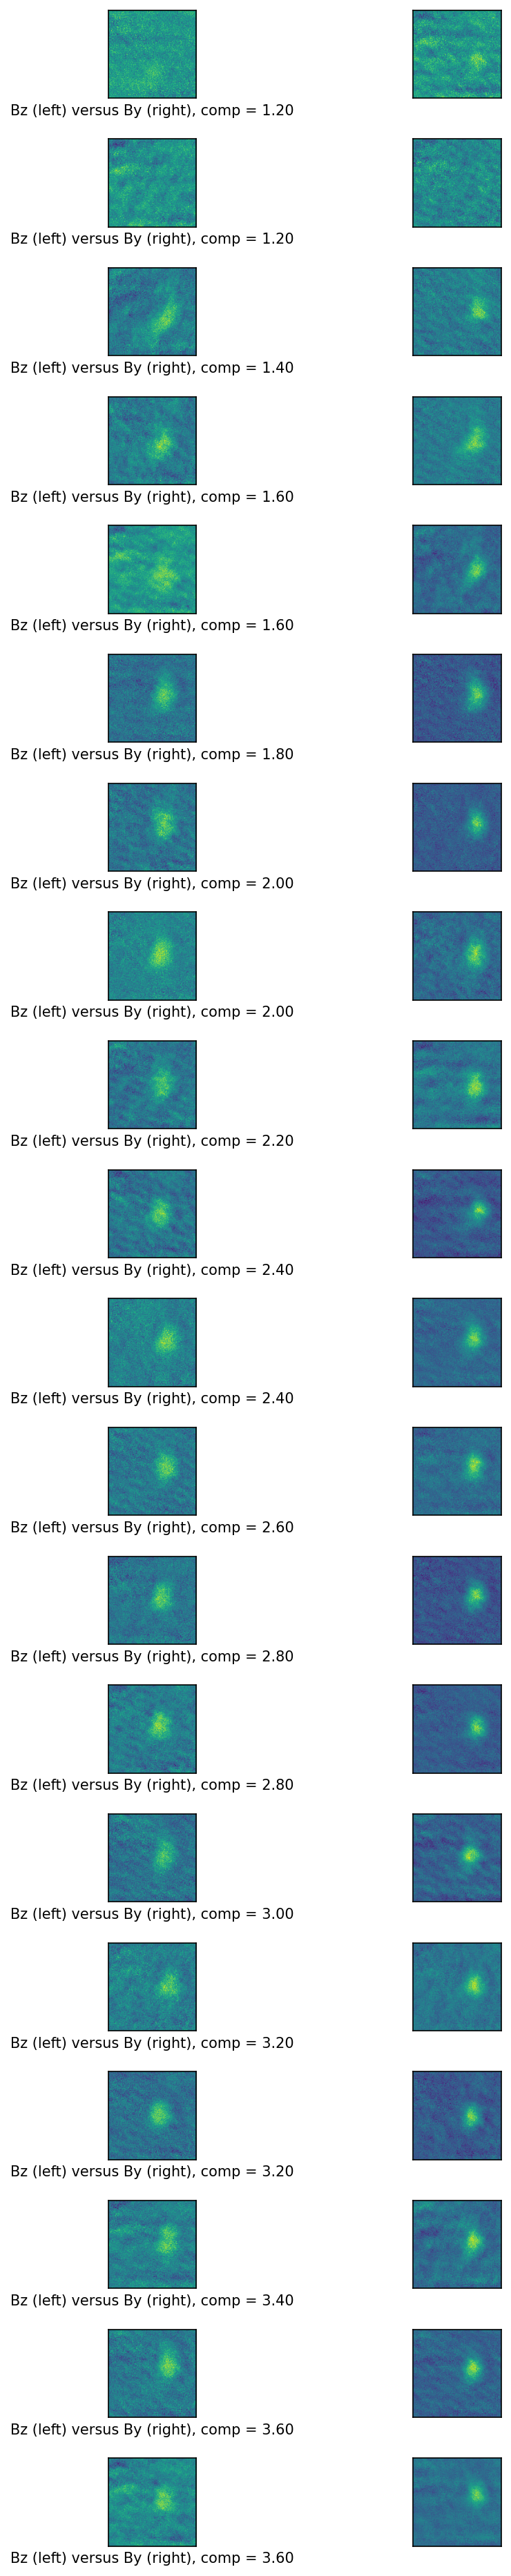

In [241]:
nrow = 20
ncol = 2
fig, ax = plt.subplots(figsize = (6,25), nrows=nrow, ncols=ncol, dpi = 150)
fig.tight_layout(pad=0.8)
i = 0
time = np.linspace(0, 200, 1000)

for row in ax:
    left, right = row
    left.get_xaxis().set_ticks([])
    left.get_yaxis().set_ticks([])
    right.get_xaxis().set_ticks([])
    right.get_yaxis().set_ticks([])
    label = "Bz (left) versus By (right), comp = " + str(round(df1_z_situ.iloc[i*2]['ODT3_Comp'],2))
    left.set_xlabel(label)
    left.imshow(df1_z_situ.iloc[i*2]['imageData'])
    right.imshow(df1_y_situ.iloc[i*2]['imageData'])
    i += 1

#plt.figure()
#plt.imshow(df.iloc[2]['imageData'])
fig.patch.set_facecolor('white')
plt.savefig('fig2.png')
plt.show()

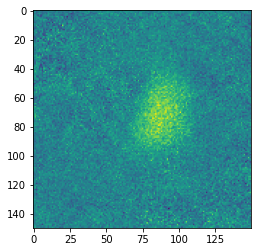

In [232]:
plt.figure()
plt.imshow(df.iloc[2]['imageData'])
plt.show()

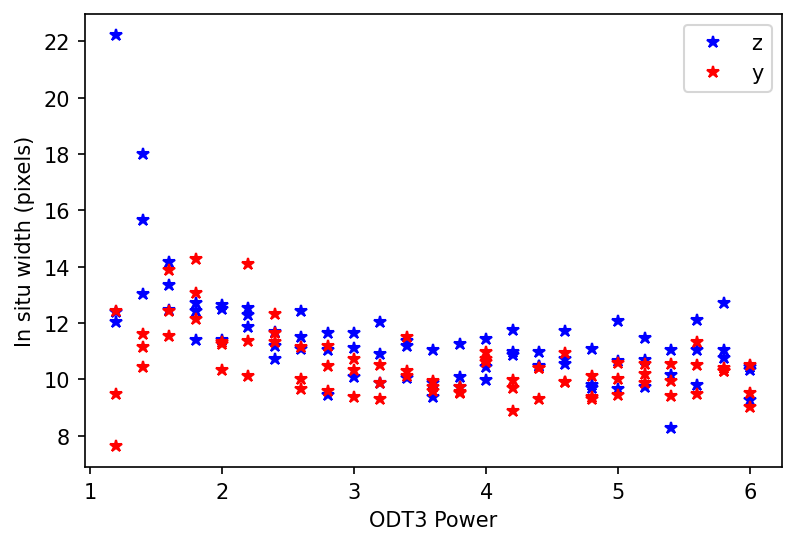

In [86]:
plt.figure(dpi = 150)
plt.plot(df_z_situ['ODT3_Comp'], df_z_situ['xWidth'], 'b*', label = 'z')
plt.plot(df_y_situ['ODT3_Comp'], df_y_situ['xWidth'], 'r*', label = 'y')
plt.xlabel('ODT3 Power')
plt.ylabel('In situ width (pixels)')
plt.legend()
plt.show()

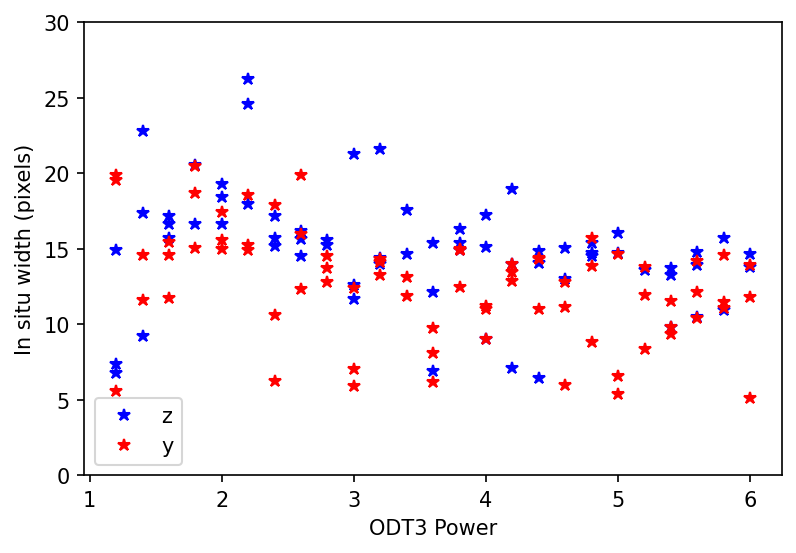

In [85]:
plt.figure(dpi = 150)
plt.plot(df_z_situ['ODT3_Comp'], df_z_situ['yWidth'], 'b*', label = 'z')
plt.plot(df_y_situ['ODT3_Comp'], df_y_situ['yWidth'], 'r*', label = 'y')
plt.legend()
plt.xlabel('ODT3 Power')
plt.ylabel('In situ width (pixels)')
plt.ylim(0,30)
plt.show()

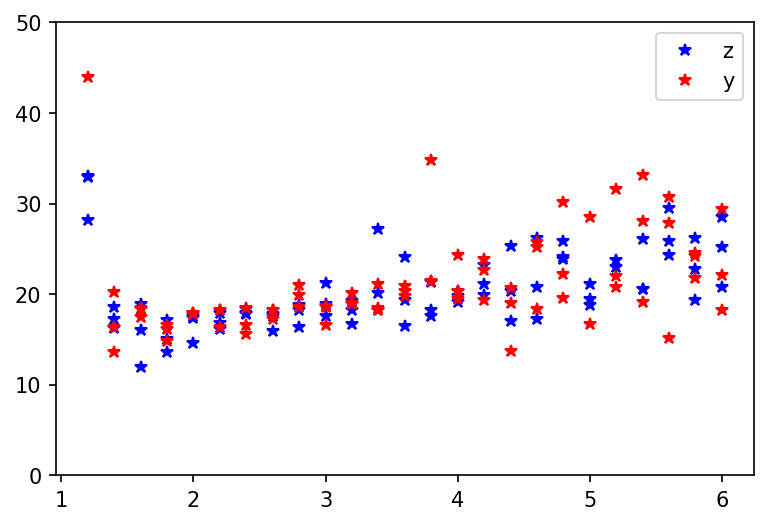

In [81]:
plt.figure(dpi = 150)
plt.plot(df_z_TOF['ODT3_Comp'], df_z_TOF['xWidth'], 'b*', label = 'z')
plt.plot(df_y_TOF['ODT3_Comp'], df_y_TOF['xWidth'], 'r*', label = 'y')
plt.legend()
plt.xlabel('ODT3 Power')
plt.ylabel('TOF width (pixels)')
plt.ylim(0,50)
plt.show()

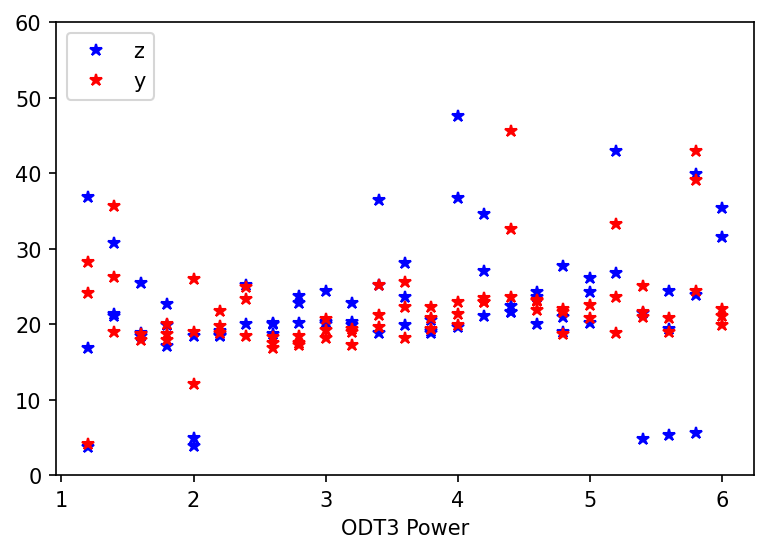

In [84]:
plt.figure(dpi = 150)
plt.plot(df_z_TOF['ODT3_Comp'], df_z_TOF['yWidth'], 'b*', label = 'z')
plt.plot(df_y_TOF['ODT3_Comp'], df_y_TOF['yWidth'], 'r*', label = 'y')
plt.ylim(0, 60)
plt.xlabel('ODT3 Power')
plt.ylabel('TOF width (pixels)')
plt.legend()
plt.show()

In [88]:
print('The pixel to micro meters convertion is ' + str(round(1/6.6*3.45, 3)))

The pixel to micro meters convertion is 0.523


In [ ]:
imageDataList = []
# [ODT3_PD], [imageID_start, imageID_end]
labels = [[['Bz', 'in_situ'], [121968, 122042]],
          [['By', 'in_situ'], [122043, 122117]],
          [['Bz', 'TOF_bandmap'], [122164, 122237]],
          [['By', 'TOF_bandmap'], [122239, 122312]]
         ]
for label in labels:
    for imageID in range(label[1][0], label[1][1]):
        imageDataList